# BO with Binary Black-box Constraint
* Contributors: Fanjin Wang
* Last updated: Jan 26, 2025
* BoTorch version: 0.12.1.dev91+g0df552162.d20250124

In this notebook, we show how to implement BO under unknown constraints learned from a classification model trained together with a GP.

To add some context, the recommendations presented by BO to assist laboratory experiments may lead to undesired experiment results, such as failures or infeasible protocols [1]. And in these cases, the underlying feasible region can only be obtained through experimentation. In such cases, these unknown constraints can be treated as an unknown variable modeled by a surrogate classification model. Note that this setting, in which we only obtain binary information about whether or not a proposed candidate is feasible or not, is different from the setting in which we observe numerical values of an outcome that is subject to some constraint.

The present code is also inspired by the implementation in [2].

[1]: [Wang, F., Parhizkar, M., Harker, A., & Edirisinghe, M. (2024). Constrained composite Bayesian optimization for rational synthesis of polymeric particles. ArXiv, abs/2411.10471](https://arxiv.org/abs/2411.10471).

[2]: [Tian, Y., Zuniga, A., Zhang, X., Dürholt, J.P., Das, P., Chen, J., Matusik, W., & Konakovic-Lukovic, M. (2024). Boundary Exploration for Bayesian Optimization With Unknown Physical Constraints. ArXiv, abs/2402.07692](https://arxiv.org/abs/2402.07692).


### Set dtype and device

In [1]:
import os
import torch

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}


### Problem setup

We begin with setting up a classical synthetic problem `Townsend` presented in [3]. The objective to be maximized is:

$$
\begin{align*}
y_{\text{obj}} &= \cos\left((x_1 - 0.1) x_2\right)^2 + x_1 \sin(3 x_1 + x_2)
\end{align*}
$$

Subjected to the constraint:
$$
y_{\text{con}} = \left(\left(2 \cos(t) - 0.5 \cos(2t) - 0.25 \cos(3t) - 0.125 \cos(4t)\right)^2 + \left(2 \sin(t)\right)^2 - x_1^2 - x_2^2\right)>0
$$ 
where $t = \arctan\left(\frac{x_1}{x_2}\right)$

Here, we follow a natural representation where $y_{\text{con}}=1$ indicates a feasible condition. We will train a classification model to predict the feasibility of the point. Note that in BoTorch's implementation, **negative values** indicate feasibility, thus we need to do conversion later when feeding feasibility into the pipeline.


[3]: Townsend, A. (2014). Constrained optimization in Chebfun. https://www.chebfun.org/examples/opt/ConstrainedOptimization.html

In [2]:
class Townsend():
    def __init__(self):
        self.dim = 2
        self.lb = torch.tensor([-2.25, 2.25], **tkwargs)
        self.ub = torch.tensor([-2.5, 1.75], **tkwargs)
        self.bounds = torch.stack([self.lb, self.ub]).T
        self._optimal_value = 1.660
        self.name = "Townsend"

    def __call__(self, x):
        return self.objective(x)

    def constraint(self, x):
        x1, x2 = x[..., 0], x[..., 1]
        t = torch.atan2(x1, x2) 
        constraint_value = (((2 * torch.cos(t) - 0.5 * torch.cos(2 * t) - 0.25 * torch.cos(3 * t) - 0.125 * torch.cos(4 * t)) ** 2 + (2 * torch.sin(t)) ** 2 - x1 ** 2 - x2 ** 2) > 0).float()
        return constraint_value
    
    def objective(self,x):
            x1, x2 = x[..., 0], x[..., 1]
            return torch.cos((x1 - 0.1) * x2) ** 2 + x1 * torch.sin(3 * x1 + x2)

townsend = Townsend()

We plot the landscape of the Townsend function as a reference. The infeasible region is masked out.

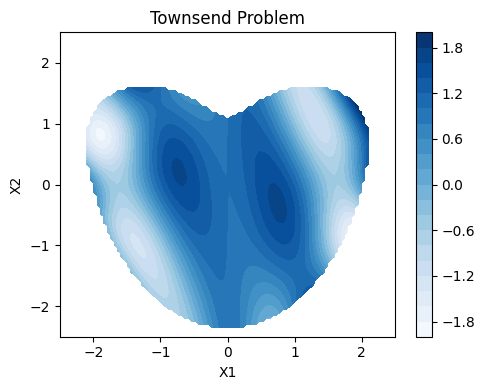

In [3]:
# Plot the townsend function and constraint
import matplotlib.pyplot as plt
import numpy as np

def plot_townsend(ax):
    x = np.linspace(-2.5, 2.5, 100)
    y = np.linspace(-2.5, 2.5, 100)
    X, Y = np.meshgrid(x, y)

    obj = townsend(torch.tensor(np.stack([X, Y], axis=-1), **tkwargs)).cpu().numpy()
    con = townsend.constraint(torch.tensor(np.stack([X, Y], axis=-1), **tkwargs)).cpu().numpy()

    #mask out the constraint region<0
    obj[con==0] = np.nan

    c = ax.contourf(X, Y, obj, levels=20,cmap='Blues')

    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_title("Townsend Problem")

    plt.colorbar(c, ax=ax, orientation='vertical')
    return ax

# Plot the townsend function and constraint
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_townsend(ax)
plt.tight_layout()
plt.show()

### Generate Training Data

In [4]:
from botorch.utils.sampling import draw_sobol_samples

def generate_initial_data(n):
    # generate training data within the problem bounds
    train_x = draw_sobol_samples(bounds=townsend.bounds, n=n, q=1).squeeze(1)
    train_obj = townsend(train_x).unsqueeze(-1)
    train_con = townsend.constraint(train_x)
    return train_x, train_obj, train_con

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


### Define Classification Model
We use [approximate GP](https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/Non_Gaussian_Likelihoods.html) implemented by GPyTorch as the surrogate for unknown constraint. The latent function is modelled by a GP, and the likelihood is modelled by a Bernoulli distribution. Followed by training, we extract the probability from the Bernoulli distribution as the feasibility prediction.

In [5]:
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.kernels.scale_kernel import ScaleKernel
from botorch.models.gpytorch import GPyTorchModel

class GP_vi(ApproximateGP, GPyTorchModel):
    def __init__(self, train_x, train_y):
        self.train_inputs = (train_x,)
        self.train_targets = train_y

        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(
            self, train_x, variational_distribution
        )
        super(GP_vi, self).__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood = gpytorch.likelihoods.BernoulliLikelihood()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#### Model initialization
We initialize the model with a `SingleTaskGP` model and the custom `GP_vi` model for the feasibility modeling.

In [6]:
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.utils.transforms import unnormalize, normalize

from functools import partial

def initialize_model(train_x, train_obj, train_con):
    '''Initialize the model for the problem.'''
    train_x = normalize(train_x, bounds=townsend.bounds)

    model_obj = SingleTaskGP(
        train_X=train_x,
        train_Y=train_obj,
        outcome_transform=Standardize(m=1),
    )
    
    mll_obj = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    fit_gpytorch_mll(mll_obj)

    model_con = GP_vi(train_x, train_con)
    mll_con = gpytorch.mlls.VariationalELBO(
        model_con.likelihood, model_con, num_data=train_con.size(0)
    )

    #make sure the GPyTorch model is in double precision
    model_con.double()
    mll_con.double()
    
    fit_gpytorch_mll(mll_con)
    model = ModelListGP(model_obj, model_con)
    
    return model

We further set up the acquisition function `qLogExpectedImprovement` and the method to optimize and get observation from Townsend function. The constraint is passed to the acquisition function as a `constraint` argument. See [here](https://botorch.org/api/acquisition.html#botorch.acquisition.monte_carlo.SampleReducingMCAcquisitionFunction) for more details. The helper functions `pass_obj` and `pass_con_unsigmoid` are used to pass the objective and constraint values to the acquisition function.

In [7]:
from botorch.acquisition import qLogExpectedImprovement
from botorch.acquisition.objective import GenericMCObjective
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim import optimize_acqf

BATCH_SIZE = 1
NUM_RESTARTS = 10 
RAW_SAMPLES = 512

def optimize_acqf_and_get_observation(model, train_obj, train_con, 
):
    """
    Optimizes the acquisition function, and returns a new candidate and observation.
    """
    # best_f is the best feasible objective value observed so far
    best_f = np.ma.masked_array(train_obj, mask=~train_con.bool()).max().item()
    
    # standardize the training data
    standard_bounds = torch.stack([torch.zeros(townsend.dim), torch.ones(townsend.dim)])
    
    acqf = qLogExpectedImprovement(
        model=model,
        best_f=best_f,
        sampler=SobolQMCNormalSampler(sample_shape=torch.Size([1024])),       objective=GenericMCObjective(pass_obj),
        constraints=[partial(pass_con_unsigmoid, model_con=model.models[1])],
    )

    # run the optimization function
    candidates, _ = optimize_acqf(
        acq_function=acqf,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    
    # observe new values
    new_x = unnormalize(candidates.detach(), townsend.bounds)
    new_obj = townsend(new_x)
    new_con = townsend.constraint(new_x)

    return new_x, new_obj, new_con, acqf

def pass_obj(Z,X=None):
    '''
    directly pass the objective to the acquisition function
    '''
    return Z[...,0]

def pass_con_unsigmoid(Z, model_con, X=None):
    '''
    pass the constraint to the acquisition function

    Note: Botorch does sigmoid transformation for the constraint by default, 
    therefore we need to unsigmoid our probability (0-1) to (-inf,inf)
    also we need to invert the probability, where -inf means the constraint is satisfied. Finally,we add 1e-8 to avoid log(0).
    '''
    y_con = Z[...,1] #get the constraint

    prob = model_con.likelihood(y_con).probs #obtain the probability of y_con(when constraint satisfied)
    prob_unsigmoid_neg = torch.log(1-prob+1e-8)-torch.log(prob+1e-8) #unsigmoid the probability and invert it to adapt to BoTorch's constraint API
    
    return prob_unsigmoid_neg


We also define some helper functions to visualize the BO process through plotting out the acquisition function value, and the underlying constraint probability and expected improvement value before subjecting to constraints.

In [8]:
def plot_helper(model, train_x,new_x, acqf,axes):

    with torch.no_grad():
        x = np.linspace(-2.5, 2.5, 100)
        y = np.linspace(-2.5, 2.5, 100)  
        X, Y = np.meshgrid(x, y)
        Z = torch.tensor(np.stack([X, Y], axis=-1)).to(**tkwargs)
        Z = normalize(Z, bounds=townsend.bounds)
        Z = Z.reshape(-1, 2).unsqueeze(1)
        # get the acquisition function value
        acq_values = acqf(Z).cpu().numpy()
        # get the constraint probability
        model_con = model.models[1]
        prob = model_con.likelihood(model_con(Z)).probs.cpu().numpy()
        # get the expected improvement value
        ei_values = model.models[0](Z).mean.cpu().numpy()

    # plot the townsend function
    plot_townsend(axes[0])

    c_acqf = axes[1].contourf(X, Y, acq_values.reshape(100,100), levels=20,cmap='Blues')

    #plot the constraint probability and set the colorbar to 0-1
    c_prob = axes[2].contourf(X, Y, prob.reshape(100,100), levels=20,cmap='RdYlGn',vmin=0,vmax=1)

    c_ei = axes[3].contourf(X, Y, ei_values.reshape(100,100), levels=20,cmap='Oranges')

    #plot the current observations
    for ax in axes:
        ax.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), color='grey', label='Observations',alpha=0.5)
        ax.scatter(new_x[:, 0].cpu(), new_x[:, 1].cpu(), marker='*' ,color='red', label='New Point')
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")

    axes[1].set_title("Acquisition Function")
  
    axes[2].set_title("Constraint Probability")

    axes[3].set_title("EI value")
    
    #add colorbar
    plt.colorbar(c_acqf, ax=axes[1])
    plt.colorbar(c_prob, ax=axes[2])
    plt.colorbar(c_ei, ax=axes[3])
    plt.tight_layout()

### Perform BO loop
We initialize the BO loop with 10 random points from SOBEL sequence. We then perform 50 iterations of BO. The acquisition function value, the underlying constraint probability, and the expected improvement value are plotted at every 10 iterations.

Iteration 0: log Regret (CEI, Sobol) = (-1.27, -1.27)




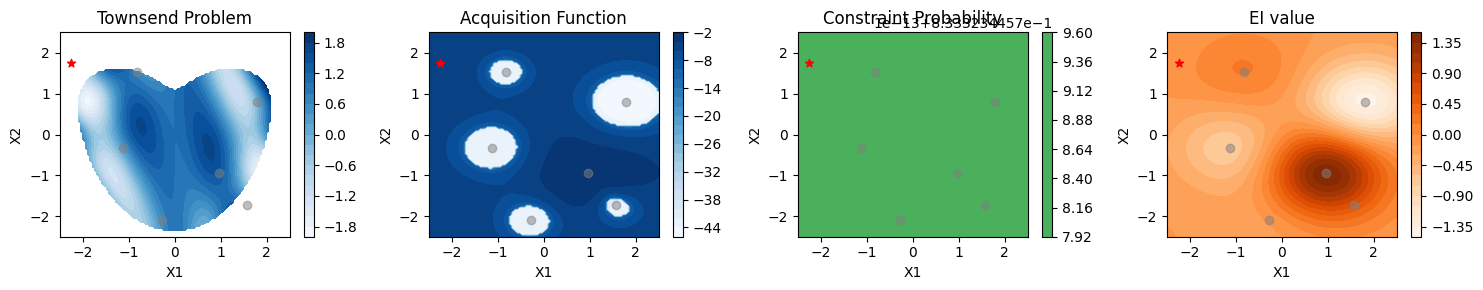

Iteration 1: log Regret (CEI, Sobel) = (-1.27, -1.27)


Iteration 2: log Regret (CEI, Sobel) = (-1.27, -1.27)


Iteration 3: log Regret (CEI, Sobel) = (-1.27, -1.27)


Iteration 4: log Regret (CEI, Sobel) = (-1.27, -1.27)


Iteration 5: log Regret (CEI, Sobel) = (-2.15, -1.27)


Iteration 6: log Regret (CEI, Sobel) = (-2.15, -1.27)


Iteration 7: log Regret (CEI, Sobel) = (-2.15, -1.27)


Iteration 8: log Regret (CEI, Sobel) = (-2.15, -1.27)


Iteration 9: log Regret (CEI, Sobel) = (-2.15, -1.27)


Iteration 10: log Regret (CEI, Sobel) = (-2.15, -1.27)




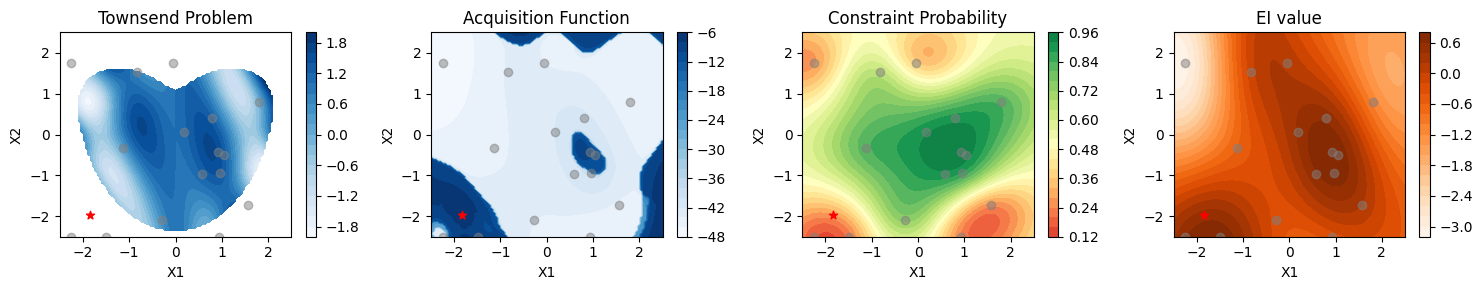

Iteration 11: log Regret (CEI, Sobel) = (-2.15, -1.27)


Iteration 12: log Regret (CEI, Sobel) = (-2.15, -1.27)


Iteration 13: log Regret (CEI, Sobel) = (-2.15, -1.27)


Iteration 14: log Regret (CEI, Sobel) = (-5.23, -1.27)


Iteration 15: log Regret (CEI, Sobel) = (-5.23, -1.27)


Iteration 16: log Regret (CEI, Sobel) = (-5.23, -1.27)


Iteration 17: log Regret (CEI, Sobel) = (-5.23, -1.27)


Iteration 18: log Regret (CEI, Sobel) = (-5.23, -1.27)


Iteration 19: log Regret (CEI, Sobel) = (-5.23, -1.27)


Iteration 20: log Regret (CEI, Sobel) = (-5.23, -1.27)




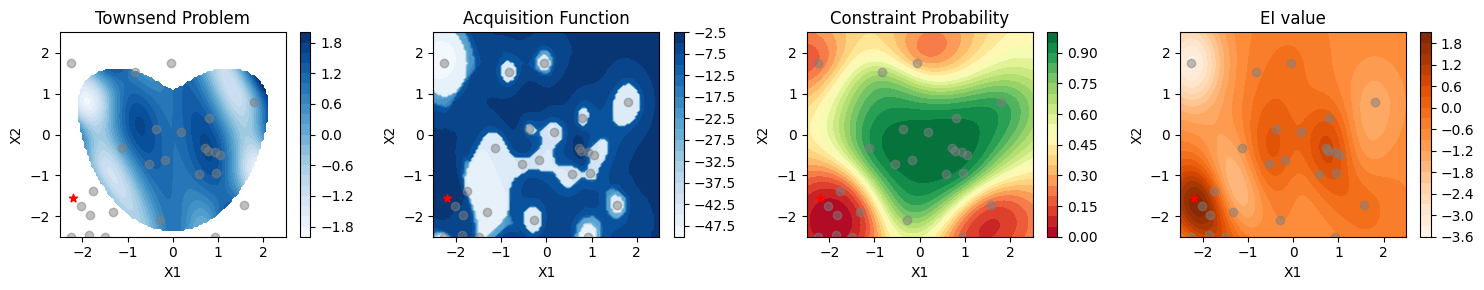

Iteration 21: log Regret (CEI, Sobel) = (-5.23, -1.27)


Iteration 22: log Regret (CEI, Sobel) = (-5.23, -1.27)


Iteration 23: log Regret (CEI, Sobel) = (-5.23, -2.38)


Iteration 24: log Regret (CEI, Sobel) = (-5.23, -2.38)


Iteration 25: log Regret (CEI, Sobel) = (-5.23, -2.38)


Iteration 26: log Regret (CEI, Sobel) = (-5.23, -2.38)


Iteration 27: log Regret (CEI, Sobel) = (-5.23, -2.38)


Iteration 28: log Regret (CEI, Sobel) = (-5.23, -2.38)




C:\Users\fj\OneDrive - University College London\UCL-PhD\0_Projects\botorch\botorch\botorch\optim\fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Iteration 29: log Regret (CEI, Sobel) = (-5.23, -2.38)


Iteration 30: log Regret (CEI, Sobel) = (-5.23, -2.38)




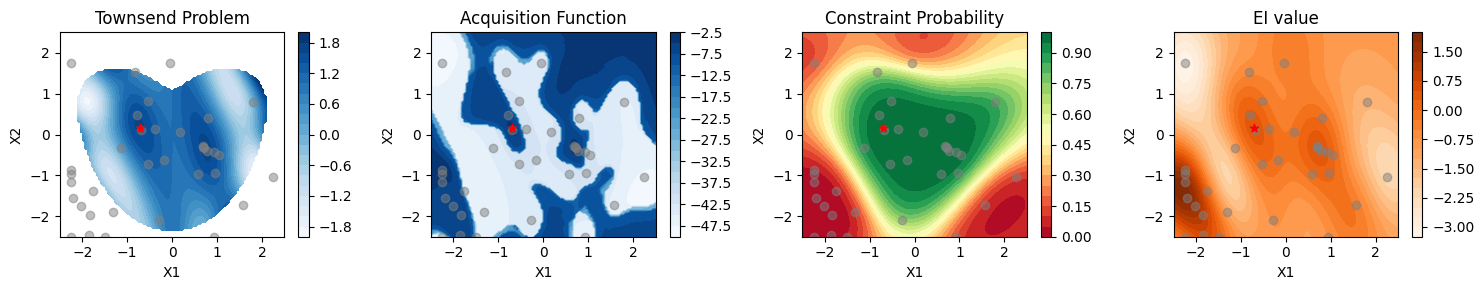

Iteration 31: log Regret (CEI, Sobel) = (-5.23, -2.38)


Iteration 32: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 33: log Regret (CEI, Sobel) = (-5.23, -2.67)




C:\Users\fj\OneDrive - University College London\UCL-PhD\0_Projects\botorch\botorch\botorch\optim\fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Iteration 34: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 35: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 36: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 37: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 38: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 39: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 40: log Regret (CEI, Sobel) = (-5.23, -2.67)




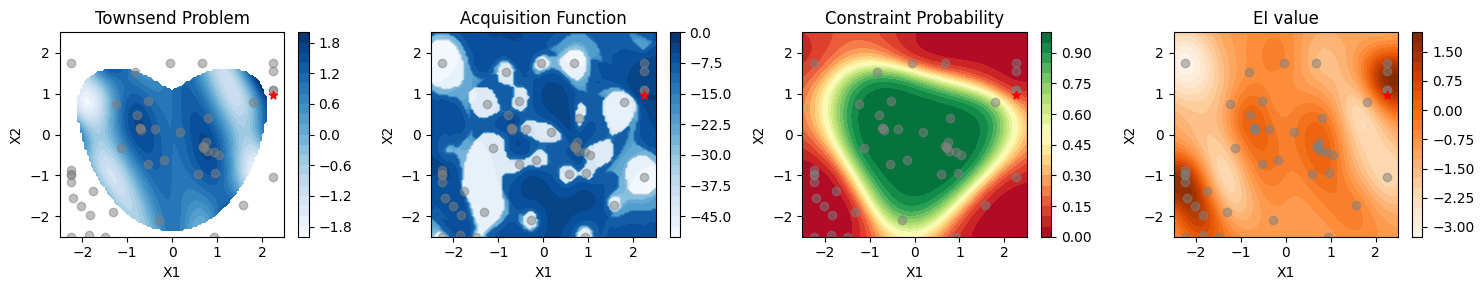

Iteration 41: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 42: log Regret (CEI, Sobel) = (-5.23, -2.67)




C:\Users\fj\OneDrive - University College London\UCL-PhD\0_Projects\botorch\botorch\botorch\optim\fit.py:104: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Iteration 43: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 44: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 45: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 46: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 47: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 48: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 49: log Regret (CEI, Sobel) = (-5.23, -2.67)


Iteration 50: log Regret (CEI, Sobel) = (-5.23, -2.67)




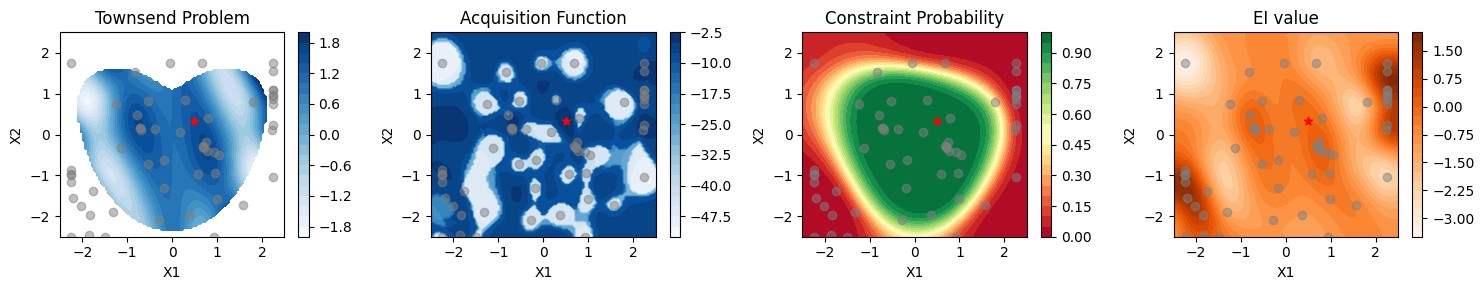

In [9]:
INIT_DATA_SIZE = 2*(townsend.dim + 1)
N_BATCH = 50
VERBOSE = True

# generate initial training data
train_x, train_obj, train_con = generate_initial_data(n=INIT_DATA_SIZE)

# add random baseline
train_x_rand, train_obj_rand, train_con_rand = (train_x, train_obj, train_con)

# initialize the model
model = initialize_model(train_x, train_obj, train_con)

# store a list of regrets at each step
optimal = torch.tensor(townsend._optimal_value, **tkwargs)

regrets_model = []
regrets_rand = []

for _ in range(N_BATCH+1):    
    # log the regrets
    best_f_model = np.ma.masked_array(train_obj, mask=~train_con.bool()).max().item()    
    regrets_model.append(optimal-best_f_model)

    best_f_rand = np.ma.masked_array(train_obj_rand, mask=~train_con_rand.bool()).max().item()
    regrets_rand.append(optimal-best_f_rand)

    # optimize the acquisition function and get new observation
    new_x, new_obj, new_con,acqf = optimize_acqf_and_get_observation(model, train_obj, train_con)

    # print the current model and random regret and iteration, plot the acquisition function every 10 iterations .2f
    if VERBOSE:
        print(f"Iteration {_}: log Regret (CEI, Sobel) = ({torch.log(regrets_model[-1]):.2f}, {torch.log(regrets_rand[-1]):.2f})")
        print("\n")
        if _ % 10 == 0:
            fig, axes = plt.subplots(1, 4, figsize=(15, 3))
            plot_helper(model, train_x, new_x, acqf,axes)
            plt.show()
            #clear the axes
            plt.pause(0.1)
            plt.close(fig)

    # include the new observation in the training data
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj.unsqueeze(-1)])
    train_con = torch.cat([train_con, new_con])
    # update the model
    model = initialize_model(train_x, train_obj, train_con)

    # execute the random baseline
    new_x_rand, new_obj_rand, new_con_rand = generate_initial_data(n=BATCH_SIZE)
    train_x_rand = torch.cat([train_x_rand, new_x_rand])
    train_obj_rand = torch.cat([train_obj_rand, new_obj_rand])
    train_con_rand = torch.cat([train_con_rand, new_con_rand]) 

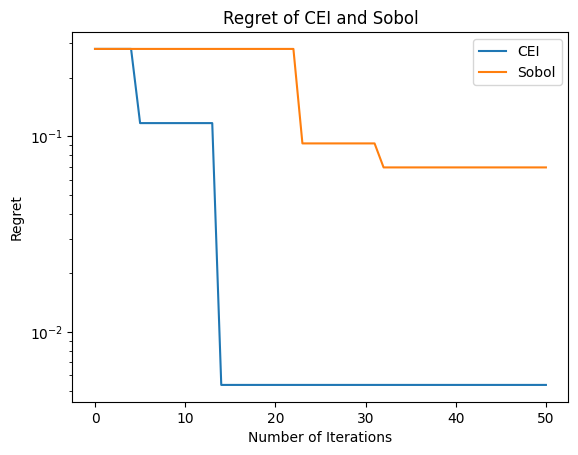

In [10]:
#plot the regret
plt.plot(regrets_model, label='CEI')
plt.plot(regrets_rand, label='Sobol')
plt.yscale("log")
plt.xlabel("Number of Iterations")
plt.ylabel("Regret")
plt.title("Regret of CEI and Sobol")
plt.legend()
plt.show()